# Installing libraries

In [ ]:
!pip install shap imbalanced-learn xgboost -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay)
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
print("All libraries loaded ✅")

All libraries loaded ✅


# Loading the dataset


In [ ]:
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

df = pd.read_csv(url)
print("Shape:", df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis

## Basic Overview

In [ ]:
# Check data types and missing values
print(df.info())
print("\nMissing values:\n", df.isnull().sum())
print("\nChurn distribution:\n", df['Churn'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# TotalCharges is read as object
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.dropna(subset=['TotalCharges'], inplace=True)

df.drop('customerID', axis=1, inplace=True)

print("Cleaned shape:", df.shape)

Cleaned shape: (7032, 20)


## Visualizing Churn Distribution

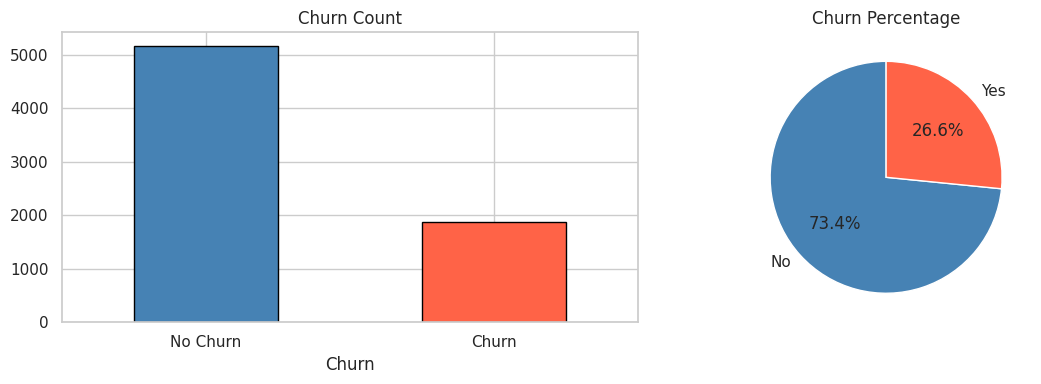

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
df['Churn'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue','tomato'], edgecolor='black')
axes[0].set_title('Churn Count')
axes[0].set_xticklabels(['No Churn', 'Churn'], rotation=0)

# Pie chart
df['Churn'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                 colors=['steelblue','tomato'], startangle=90)
axes[1].set_ylabel('')
axes[1].set_title('Churn Percentage')

plt.tight_layout()
plt.show()

## Chrun vs. Key Features

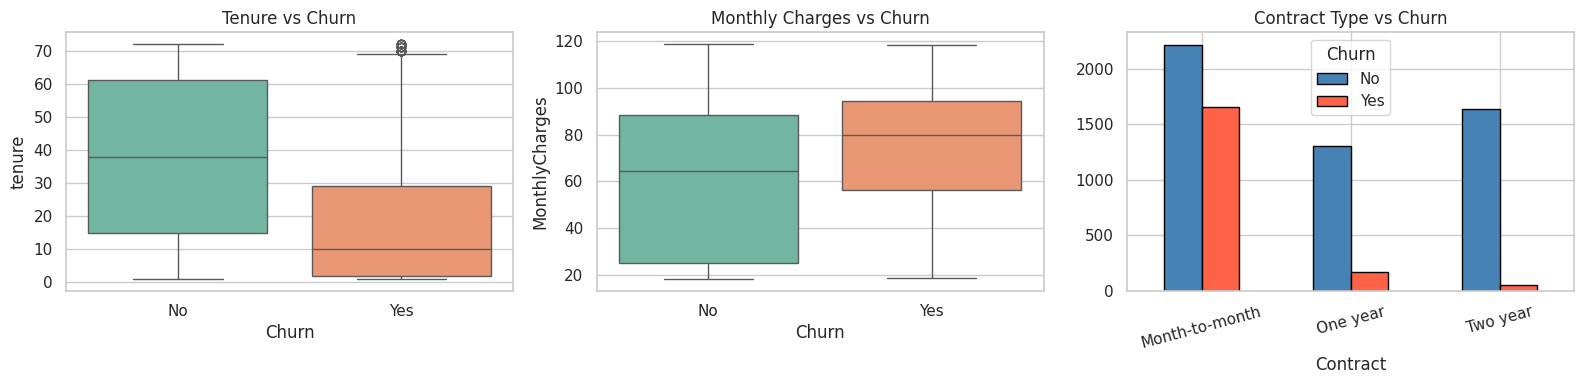

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Tenure vs Churn
sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Tenure vs Churn')

# Monthly Charges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1], palette='Set2')
axes[1].set_title('Monthly Charges vs Churn')

# Contract type vs Churn
contract_churn = df.groupby(['Contract', 'Churn']).size().unstack()
contract_churn.plot(kind='bar', ax=axes[2], color=['steelblue','tomato'], edgecolor='black')
axes[2].set_title('Contract Type vs Churn')
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# Feature Engineering & Preprocessing

In [ ]:
# Encode binary columns (Yes/No → 1/0)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
               'Churn', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0,
                            'No phone service': 0,
                            'No internet service': 0})

# Encode gender
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# One-hot encode multi-category columns
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'],
                    drop_first=True)

print("Final shape:", df.shape)
df.head()

Final shape: (7032, 24)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,False,False,True,False,False,False,True
2,1,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,False,False,True,False,False,False,False
4,0,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,True,False,False,False,False,True,False


# Train/Test Split + Handle Imbalance


In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split BEFORE applying SMOTE (important — never apply SMOTE on test data)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # only transform, never fit on test data

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", pd.Series(y_train).value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_res).value_counts().to_dict())

Before SMOTE: {0: 4130, 1: 1495}
After SMOTE: {0: 4130, 1: 4130}


# Train & Compare Models

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {'model': model, 'auc': auc, 'y_pred': y_pred, 'y_prob': y_prob}
    print(f"\n{'='*40}")
    print(f"Model: {name} | AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))


Model: Logistic Regression | AUC: 0.8340
              precision    recall  f1-score   support

    No Churn       0.90      0.72      0.80      1033
       Churn       0.50      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407


Model: Random Forest | AUC: 0.8132
              precision    recall  f1-score   support

    No Churn       0.85      0.84      0.84      1033
       Churn       0.57      0.60      0.59       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.72      1407
weighted avg       0.78      0.77      0.78      1407


Model: XGBoost | AUC: 0.8193
              precision    recall  f1-score   support

    No Churn       0.86      0.84      0.85      1033
       Churn       0.58      0.61      0.60       374

    accuracy                           0.78      1407
   macro avg       0

## ROC Curve Comparision

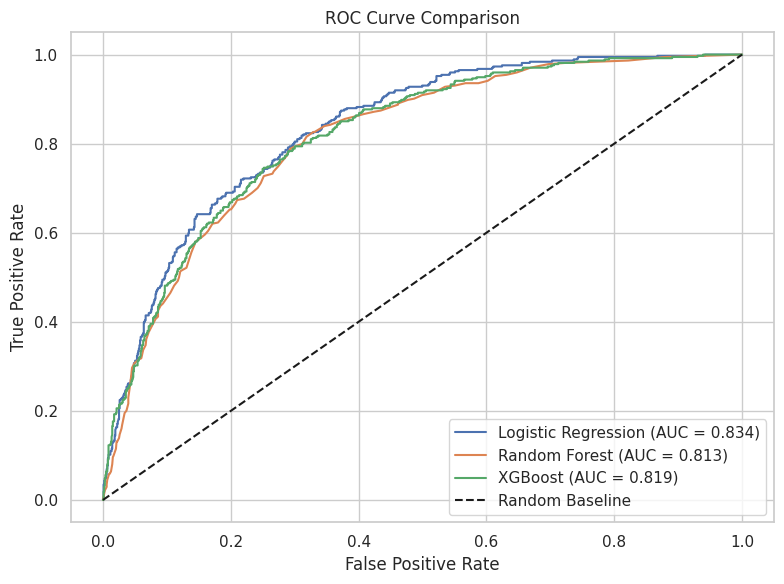

In [ ]:
plt.figure(figsize=(8, 6))

for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['auc']:.3f})")

plt.plot([0,1], [0,1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# SHAP Explainability

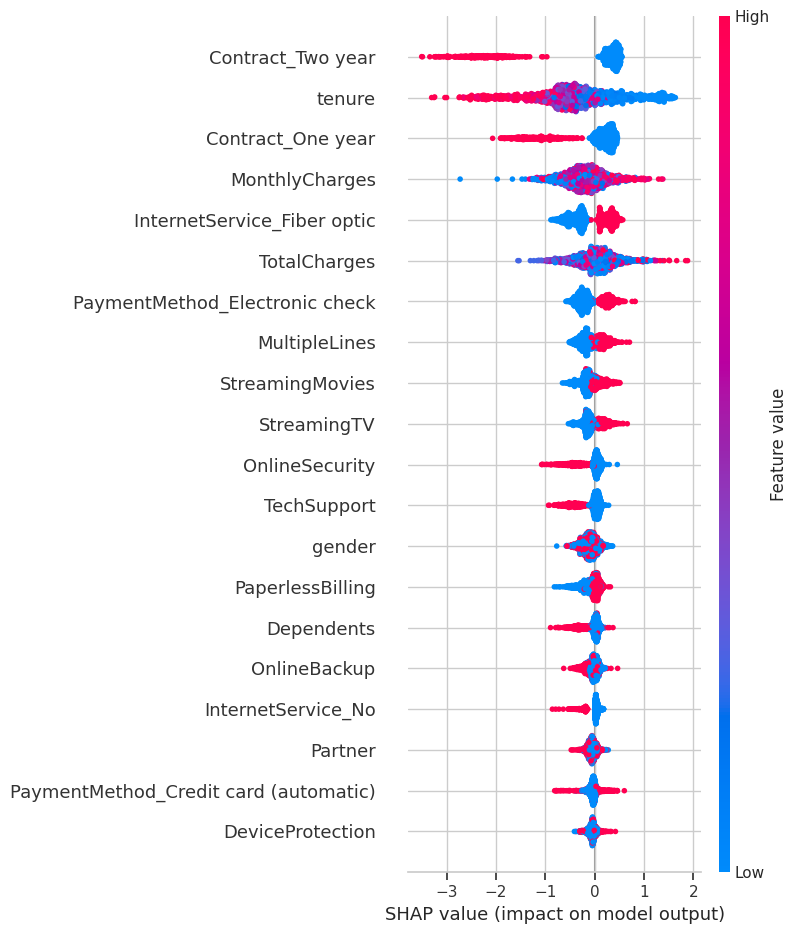

In [ ]:
best_model = results['XGBoost']['model']

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=df.drop('Churn', axis=1).columns.tolist())

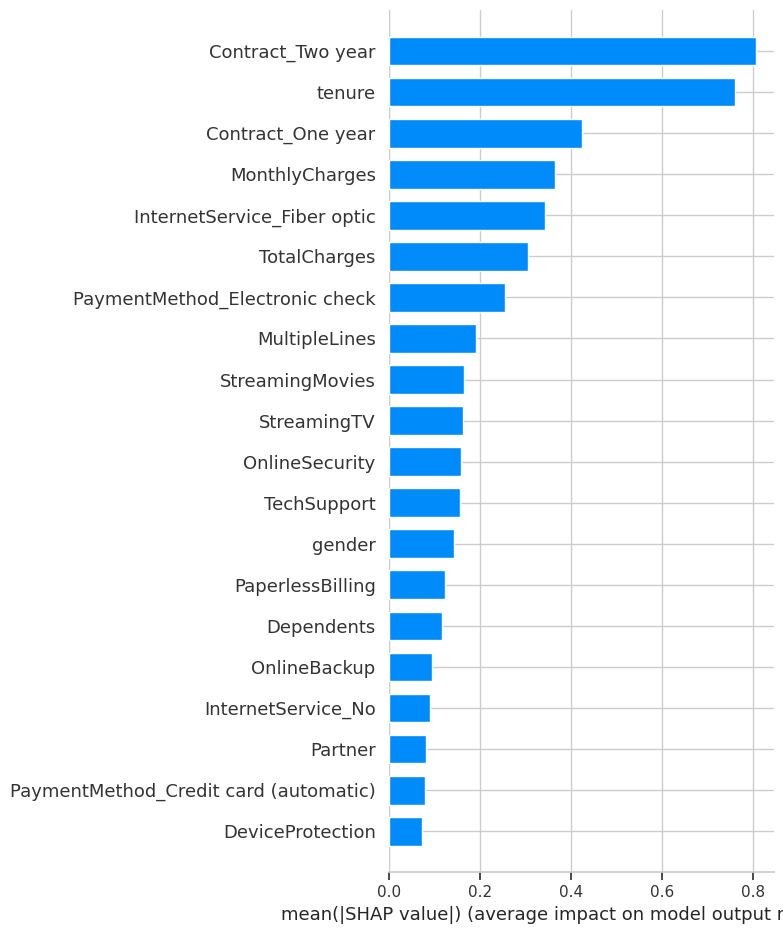

In [ ]:
shap.summary_plot(shap_values, X_test,
                  feature_names=df.drop('Churn', axis=1).columns.tolist(),
                  plot_type='bar')

# Saving the model

In [ ]:
import pickle

# Save model and scaler
with open('churn_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Download to your local machine from Colab
from google.colab import files
files.download('churn_model.pkl')
files.download('scaler.pkl')

print("Model saved ✅")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved ✅
